# BME1063 HW1 Visualization and Analyzation

## package information

* python version 3.7.6
* numpy version 1.18.1
* pandas version 1.0.3
* matplotlib version 3.1.3


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
figure_path='../FinalReport/images'

## Runtime vidualization

* Runtime information path: `FinalReport/time_summary`

In [3]:
info_path = '../FinalReport/time_summary'

# read data from time summary
bwa_time = []
bowtie_time = []

with open(os.path.join(info_path, 'bwa_time_summary.txt'), 'r') as f:
    line = f.readline()
    # loop over the file and find 3 line start with 'user'
    while line != '':
        if line.split()[0] == 'user':
            time = line.split()[1]
            bwa_time.append(float(time.split('m')[1][:-1]) + float(time.split('m')[0])*60)
        line = f.readline()

with open(os.path.join(info_path, 'bowtie2_time_summary.txt'), 'r') as f:
    line = f.readline()
    # loop over the file and find 3 line start with 'user'
    while line != '':
        if line.split()[0] == 'user':
            time = line.split()[1]
            bowtie_time.append(float(time.split('m')[1][:-1]) + float(time.split('m')[0])*60)
        line = f.readline()

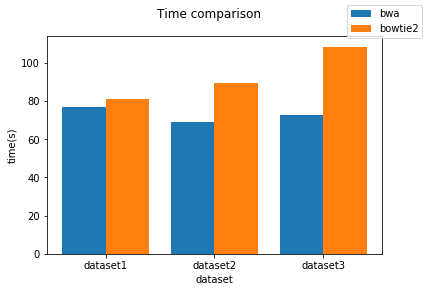

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(3), bwa_time, width=0.4, label='bwa')
ax.bar([i + 0.4 for i in range(3)], bowtie_time, width=0.4, label='bowtie2')
# set ticks, tick labels and labels
ax.set(
    xticks=[i+0.2 for i in range(3)], 
    xticklabels=['dataset1', 'dataset2', 'dataset3'],
    xlabel='dataset', 
    ylabel='time(s)', 
)
fig.legend()
fig.suptitle('Time comparison')
fig.savefig(os.path.join(figure_path, 'time_comparison.svg'))

## mapping quality analyzation and visualization

In [5]:
quality_path = '../FinalReport/mapping_summary'
bwa_quality = os.path.join(quality_path, 'bwa_mapping')
bowtie2_quality = os.path.join(quality_path, 'bowtie2_mapping')
dwgsim_eval_cols = [ # data types given by dwgsim_eval
    'thr',
    'mc',
    'mi',
    'mu',
    'um',
    'uu',
    'mc+mi+mu+um+uu',
    "mc'",
    "mi'",
    "mu'",
    "um'",
    "uu'",
    "mc'+mi'+mu'+um'+uu'",
    "mc/(mc'+mi'+mu')",
    "mc/(mc'+mi')",
    "um/(um'+uu')",
    "mc'/(mc'+mi'_mu')",
    "mc'/(mc'+mi')",
    "um'/(um'+uu')"
 ]

In [6]:
# read data for mapping quality
bwa_dfs = [pd.read_csv(os.path.join(bwa_quality, name), delimiter=r"\s+", header=None) for name in os.listdir(bwa_quality)] 
# the code is indeed ugly but it is the simplest way to do the job
for df in bwa_dfs:
    df.columns=dwgsim_eval_cols

bowtie2_dfs = [pd.read_csv(os.path.join(bowtie2_quality, name), delimiter=r"\s+", header=None) for name in os.listdir(bowtie2_quality)] 
for df in bowtie2_dfs:
    df.columns=dwgsim_eval_cols

### TP, TN, FP, FN

The definition for TP, TN, FP, FN is as follows:

* TP: true positive, number of sequences correctly mapped
* TN: true negative, number of sequences correctly unmapped
* FN: false negative, unmapped sequences should be mapped
* FP: false positive, mapped sequences should not be mapped, including wrongly mapped ones

In [7]:
# calculate TP, TN, FN, FP
for df in bwa_dfs:
    df['TP'] = df['mc']
    df['TN'] = df['uu']
    df['FP'] = df['mi'] + df['um']
    df['FN'] = df['mu']

for df in bowtie2_dfs:
    df['TP'] = df['mc']
    df['TN'] = df['uu']
    df['FP'] = df['mi'] + df['um']
    df['FN'] = df['mu']

for i in range(3):
    bwa_dfs[i] = bwa_dfs[i][['thr', 'TP', 'TN', 'FP', 'FN']]
    bowtie2_dfs[i] = bowtie2_dfs[i][['thr', 'TP', 'TN', 'FP', 'FN']]

### Precision and Recall

calculate Precision and Recall as follows:

$ Precision = \frac{TP}{TP + FP} $
$ Recall = \frac{TP}{TP + FN} $

$ Fscore = \frac{2*Precision*Recall}{Precision+Recall} $

In [8]:
mapping_compare = pd.DataFrame(
    columns = ['software', 'dataset', 'precision', 'recall']
)
for i in range(3):
    df =bwa_dfs[i]
    mapping_compare = mapping_compare.append(
        {
            'software': 'bwa', 
            'dataset': 'dataset' + str(i+1), 
            'precision': df['TP'].sum() / (df['TP'].sum() + df['FP'].sum()), 
            'recall': df['TP'].sum() / (df['TP'].sum() + df['FN'].sum())
        }, 
        ignore_index=True, 
    )
    df =bowtie2_dfs[i]
    mapping_compare = mapping_compare.append(
        {
            'software': 'bowtie2', 
            'dataset': 'dataset' + str(i + 1), 
            'precision': df['TP'].sum() / (df['TP'].sum() + df['FP'].sum()), 
            'recall': df['TP'].sum() / (df['TP'].sum() + df['FN'].sum())
        }, 
        ignore_index=True, 
    )

mapping_compare['Fscore'] = 2*mapping_compare['precision']*mapping_compare['recall']/(mapping_compare['precision'] + mapping_compare['recall'])

mapping_compare.to_csv(os.path.join(quality_path, 'precision_recall.csv'))
mapping_compare

,software,dataset,precision,recall,Fscore
0,bwa,dataset1,0.930225,1.000000,0.963852
1,bowtie2,dataset1,0.909904,0.999397,0.952553
2,bwa,dataset2,0.915926,1.000000,0.956119
3,bowtie2,dataset2,0.883572,0.998894,0.937701
4,bwa,dataset3,0.923573,1.000000,0.960268
5,bowtie2,dataset3,0.900112,0.999278,0.947106


### Cumulative precision

Since a mapping quality score is made in each alignment, we can further validate the performance by computing `Cumulative precision`, defined as follows:

$ \mbox{Cumulative precision} = \frac{\mbox{TP considering cases with score higher than threshold}}{\mbox{TP + FP considering cases with score higher than threshold}} $

$ \mbox{Cumulative recall} = \frac{\mbox{TP considering cases with score higher than threshold}}{\mbox{TP + FN considering cases with score higher than threshold}} $

In [9]:
def calculate_cumulative_precision_recall(df):
    for i in range(df.shape[0]):
        # select first i+1 rows
        temp=df.loc[range(i+1)]
        df.loc[i, 'cumulative_precision'] = temp['TP'].sum() / (temp['TP'].sum() + temp['FP'].sum())
        df.loc[i, 'cumulative_recall'] = temp['TP'].sum() / (temp['TP'].sum() + temp['FN'].sum())

In [10]:
for i in range(3):
    calculate_cumulative_precision_recall(bwa_dfs[i])
    calculate_cumulative_precision_recall(bowtie2_dfs[i])

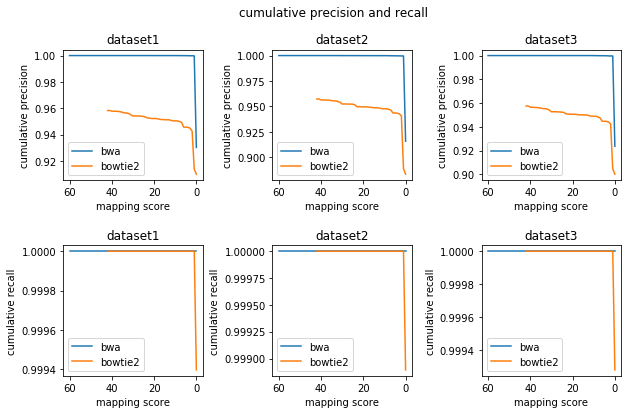

In [11]:
fig, axes = plt.subplots(2,3, figsize=(10,6), )
for i in range(3):
    axes[0, i].plot(-bwa_dfs[i]['thr'], bwa_dfs[i]['cumulative_precision'], label='bwa')
    axes[0, i].plot(-bowtie2_dfs[i]['thr'], bowtie2_dfs[i]['cumulative_precision'], label='bowtie2')
    axes[0, i].set(xticks=[-60,-40,-20,0], xticklabels=[60,40,20,0], xlabel='mapping score', ylabel='cumulative precision')
    axes[0, i].legend()
    axes[0, i].set_title('dataset{}'.format(str(i+1)))

    axes[1, i].plot(-bwa_dfs[i]['thr'], bwa_dfs[i]['cumulative_recall'], label='bwa')
    axes[1, i].plot(-bowtie2_dfs[i]['thr'], bowtie2_dfs[i]['cumulative_recall'], label='bowtie2')
    axes[1, i].set(xticks=[-60,-40,-20,0], xticklabels=[60,40,20,0], xlabel='mapping score', ylabel='cumulative recall')
    axes[1, i].legend()
    axes[1, i].set_title('dataset{}'.format(str(i+1)))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('cumulative precision and recall')
fig.savefig(os.path.join(figure_path, 'cumulative_precision_recall.svg'), dpi=72)

### TP, TN, FP, FN distribution

if we plot TP, TN, FP, FN against the mapping quality

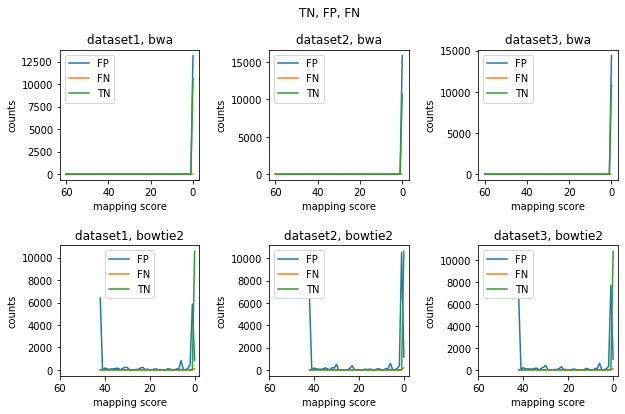

In [19]:
fig, axes = plt.subplots(2,3, figsize=(10,6), )
for i in range(3):
    axes[0, i].plot(-bwa_dfs[i]['thr'], bwa_dfs[i]['FP'], label='FP')
    axes[0, i].plot(-bwa_dfs[i]['thr'], bwa_dfs[i]['FN'], label='FN')
    # axes[0, i].plot(-bwa_dfs[i]['thr'], bwa_dfs[i]['TP'], label='TP')
    axes[0, i].plot(-bwa_dfs[i]['thr'], bwa_dfs[i]['TN'], label='TN')
    axes[0, i].set(xticks=[-60,-40,-20,0], xticklabels=[60,40,20,0], xlabel='mapping score', ylabel='counts')
    axes[0, i].legend()
    axes[0, i].set_title('dataset{}, bwa'.format(str(i+1)))

    axes[1, i].plot(-bowtie2_dfs[i]['thr'], bowtie2_dfs[i]['FP'], label='FP')
    axes[1, i].plot(-bowtie2_dfs[i]['thr'], bowtie2_dfs[i]['FN'], label='FN')
    # axes[1, i].plot(-bowtie2_dfs[i]['thr'], bowtie2_dfs[i]['TP'], label='TP')
    axes[1, i].plot(-bowtie2_dfs[i]['thr'], bowtie2_dfs[i]['TN'], label='TN')
    axes[1, i].set(xticks=[-60,-40,-20,0], xticklabels=[60,40,20,0], xlabel='mapping score', ylabel='counts')
    axes[1, i].legend()
    axes[1, i].set_title('dataset{}, bowtie2'.format(str(i+1)))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('TN, FP, FN')
fig.savefig(os.path.join(figure_path, 'TN_FP_FN.svg'), dpi=72)